In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from sklearn.metrics import mean_squared_error  # Important!
from sklearn.decomposition import PCA           # Important!
from IPython.display import display

In [2]:
def load_data(filename):
    path = os.path.join("..", "data", "tabular", filename)
    data = pl.read_csv(path).to_numpy()
    X = data[:, :-1].astype(float)
    return X

In [3]:
# Load the dataset
X_train = load_data("train_processed.csv")

# Print out the data frame for the dataset
feat_cols_train = ['feature '+str(i) for i in range(X_train.shape[1])]
normalised_train = pd.DataFrame(X_train,columns=feat_cols_train)
normalised_train.tail()

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 96,feature 97,feature 98,feature 99,feature 100,feature 101,feature 102,feature 103,feature 104,feature 105
3485,0.037058,-0.892437,-0.853279,-0.785172,-0.974276,-0.894686,-0.194773,-0.100563,-0.303624,-0.602996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3486,-0.366712,-0.236922,-0.020249,0.335127,0.591421,0.623267,0.451739,0.034959,-0.316667,-0.155741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3487,-1.022839,-0.930255,-0.954252,-0.988863,-0.681503,-0.631240,-0.617492,-0.494809,-1.503547,-1.602745,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3488,-0.909278,-0.842013,-0.828035,-0.925209,-0.974276,-0.869596,-0.891016,-0.938336,-1.020969,-1.037098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3489,1.172662,1.200169,1.241917,0.958929,0.515046,-0.141982,-0.754254,-1.332582,-0.603605,-0.747697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# # Experimenting with Principle Components

# # n_components decides how many first n columns for U and V and singular values from Σ to keep 
# pca_train = PCA(n_components=20)

# principal_components_train = pca_train.fit_transform(X_train)
# principal_train_Df = pd.DataFrame(data = principal_components_train)
# principal_train_Df.columns = [f'PC {i}' for i in range(len(principal_train_Df.columns))]   

# print('Explained variability per principal component: {}'.format(pca_train.explained_variance_ratio_))

# principal_train_Df.tail()

---
Transforming: $X_{PCA} = XV_k$

Inverse transforming $\hat{X} = XV_kV_k^T$

In [5]:
class PCAReducer:
    def __init__(self, X, variance):
        self.X = X
        self.variance = variance
    
    def train_pca(self):
        """
        ### Trains PCA on a given dataset and variance.

        ### Input:
        X, variance

        ### Output
        Array in the following order: 
        
        0. New X with PCA reduction
        1. Optimal k for given variance
        2. Record of Error Reconstruction
        3. Record of Explained Variances
        """
        pca = PCA(n_components=None) # PCA with all components
        pca.fit(self.X)

        reconstructed_errors = []
        explained_variances = []
        k_range = range(1, self.X.shape[1] + 1)

        for k in k_range:
            # Init PCA with k components
            pca = PCA(n_components=k)
            
            # Fit n' Transform
            X_reduced = pca.fit_transform(self.X)

            X_reconstruct = pca.inverse_transform(X_reduced) # Reconstruction Error
            mse = mean_squared_error(self.X, X_reconstruct) # Calculate squared error for each data point
            reconstructed_errors.append(mse)

            explained_variances.append(np.sum(pca.explained_variance_ratio_))

        # Determine the exact value for given variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        # Determine exact k for given variance by using argmax
        k_variance = np.argmax(cumulative_variance >= self.variance) + 1  # +1 because index starts at 0

        print(f"Optimal k for {self.variance}% variance: {k_variance}")

        # Reduce the dataset's components
        # Create reduced datasets through new PCA with k components
        final_pca = PCA(n_components=k_variance)

        # Fit on dataset
        X_pca = final_pca.fit_transform(self.X)

        print(f"Original Shape: {self.X.shape}\nReduced Shape: {X_pca.shape}")

        return X_pca, k_variance, reconstructed_errors, explained_variances

Optimal k for 0.95% variance: 39
Original Shape: (3490, 106)
Reduced Shape: (3490, 39)

Optimal k for 0.95% variance: 39
Original Shape: (3490, 106)
Reduced Shape: (3490, 39)


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
3485,-5.353066,1.658779,0.139394,2.389450,0.537076,0.518602,-0.166838,-0.243960,-0.677697,-1.110615,...,0.065303,0.403505,0.116934,0.202118,0.057122,-0.134645,0.363393,-0.281083,0.053457,-0.764946
3486,-4.709475,3.899986,-1.583527,-0.536559,0.473616,-1.601771,0.143427,0.165950,0.426160,-0.357643,...,0.277616,-0.418588,-0.567279,-0.347850,0.177245,-0.272257,0.354766,-0.084329,-0.229151,0.003916
3487,-4.335660,-3.332717,-3.443294,0.839610,-1.947579,0.982126,1.171903,-1.192766,-1.653330,0.715533,...,-0.299453,0.361297,-0.635454,-0.367275,0.334791,-0.364278,-0.403268,-0.560295,0.536635,0.040072
3488,1.376255,-5.119061,-1.278018,-1.155185,4.806380,0.613720,0.020980,-0.748997,-1.279468,-0.629356,...,-0.773658,-0.315672,0.860484,-0.317657,0.522974,0.562813,0.296625,0.176284,0.767711,-0.256225
3489,-5.360911,1.662636,0.519372,0.245089,-0.445181,-1.942338,-0.674253,-0.262029,0.512072,0.624212,...,-0.688666,0.170307,-0.335741,-0.046082,0.337908,0.640752,-0.517531,0.231552,-1.008297,-0.144597




Plotting RE and EV ...


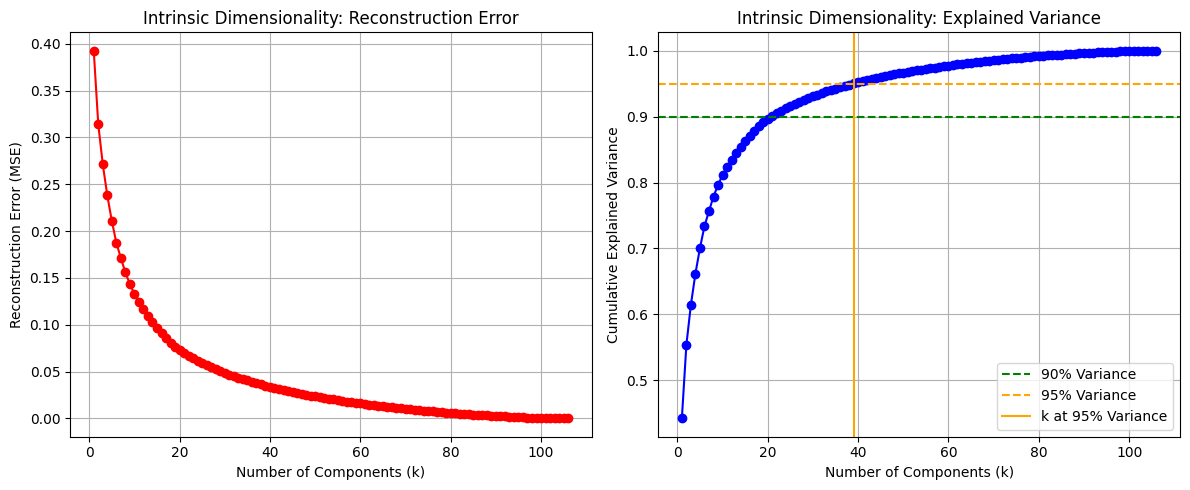

In [9]:
# This code demonstrates some use cases of the PCA reduction class
variance = 0.95
X_pca_reduced = PCAReducer(X_train, variance)
result = X_pca_reduced.train_pca()

print("\n=====================================================")
# This is how the class would be called for training
X_train_pca = PCAReducer(X_train, 0.95).train_pca()[0]
X_train_pca_Df = pd.DataFrame(data=X_train_pca)
display(X_train_pca_Df.tail())

print("\n\nPlotting RE and EV ...\n=====================================================")
# Plotting Reconstruction Error (optional for visualization of Error Reconstrucion and Explained Variance)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, X_train.shape[1] + 1), result[2], marker='o', color='red')
plt.xlabel('Number of Components (k)')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Intrinsic Dimensionality: Reconstruction Error')
plt.grid(True)

# Plotting Explained Variance
plt.subplot(1, 2, 2)
plt.plot(range(1, X_train.shape[1] + 1), result[3], marker='o', color='blue')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance') # Threshold line
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Variance') # Threshold line
plt.axvline(x=result[1], color='orange', linestyle='-', label=f'k at {int(variance*100)}% Variance')
plt.xlabel('Number of Components (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('Intrinsic Dimensionality: Explained Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()